In [294]:
import numpy as np
import pandas as pd
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score

import kerastuner as kt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/kakr-4th-competition/train.csv
/kaggle/input/kakr-4th-competition/test.csv
/kaggle/input/kakr-4th-competition/sample_submission.csv


In [295]:
train_df = pd.read_csv('../input/kakr-4th-competition/train.csv')
test_df = pd.read_csv('../input/kakr-4th-competition/test.csv')

# 1. Data Labeling

[Reference]  
https://www.kaggle.com/werooring/basic-eda-lgbm-modeling-public-score-0-87714  
https://www.kaggle.com/subinium/kakr-eda

In [296]:
train_df.drop(['id'], axis=1, inplace=True)
test_df.drop(['id'], axis=1, inplace=True)

In [297]:
y = train_df['income'] != '<=50K'
X = train_df.drop(['income'], axis=1)

In [298]:
# 라벨 인코더 생성
LE_encoder = OrdinalEncoder(list(X.columns))

# train, test 데이터에 인코딩 적용
X = LE_encoder.fit_transform(X, y)
test = LE_encoder.transform(test)

In [299]:
X['income'] = y

In [300]:
X.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,40,1,168538,1,9,1,1,1,1,1,0,0,60,1,True
1,17,1,101626,2,5,2,2,2,1,1,0,0,20,1,False
2,18,1,353358,3,10,2,3,2,1,1,0,0,16,1,False
3,21,1,151158,3,10,2,4,2,1,2,0,0,25,1,False
4,24,1,122234,3,10,2,5,3,2,2,0,0,20,2,False


In [301]:
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

In [302]:
y_train = X_train.income
X_train = X_train.drop(['income'], axis=1)
y_val = X_val.income
X_val = X_val.drop(['income'], axis=1)

In [303]:
#batch_size = 5
#train_ds = df_to_dataset(X_train, batch_size=batch_size)
#val_ds = df_to_dataset(X_val, shuffle=False, batch_size=batch_size)
#test_ds = df_to_dataset(test, )

# 2. Let's Start Building Basic NN

In [304]:
#https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-kerasfrom keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [305]:
model = tf.keras.Sequential([
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [306]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=[f1, 'acc'])

In [307]:
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
652/652 [==============================] - ETA: 0s - loss: 119.1572 - f1: 0.3333 - acc: 0.75 - ETA: 0s - loss: 263.5704 - f1: 0.3329 - acc: 0.67 - ETA: 0s - loss: 209.9407 - f1: 0.3392 - acc: 0.69 - ETA: 0s - loss: 169.5319 - f1: 0.3303 - acc: 0.68 - ETA: 0s - loss: 151.6904 - f1: 0.3319 - acc: 0.68 - ETA: 0s - loss: 146.3690 - f1: 0.3235 - acc: 0.69 - ETA: 0s - loss: 128.4899 - f1: 0.3316 - acc: 0.69 - ETA: 0s - loss: 117.9358 - f1: 0.3342 - acc: 0.69 - ETA: 0s - loss: 107.0315 - f1: 0.3467 - acc: 0.69 - ETA: 0s - loss: 102.7306 - f1: 0.3330 - acc: 0.68 - ETA: 0s - loss: 98.6945 - f1: 0.3303 - acc: 0.6876 - ETA: 0s - loss: 98.5273 - f1: 0.3245 - acc: 0.686 - ETA: 0s - loss: 94.7289 - f1: 0.3284 - acc: 0.687 - ETA: 0s - loss: 93.8343 - f1: 0.3238 - acc: 0.684 - ETA: 0s - loss: 91.1782 - f1: 0.3286 - acc: 0.685 - ETA: 0s - loss: 91.6340 - f1: 0.3237 - acc: 0.685 - ETA: 0s - loss: 90.3329 - f1: 0.3243 - acc: 0.685 - ETA: 0s - loss: 89.5358 - f1: 0.3215 - acc: 0.686 - ETA: 0s -

652/652 [==============================] - ETA: 0s - loss: 2.4216 - f1: 0.7742 - acc: 0.78 - ETA: 0s - loss: 140.0372 - f1: 0.2594 - acc: 0.65 - ETA: 0s - loss: 111.1460 - f1: 0.3118 - acc: 0.66 - ETA: 0s - loss: 93.9789 - f1: 0.3174 - acc: 0.6775 - ETA: 0s - loss: 83.5925 - f1: 0.3231 - acc: 0.683 - ETA: 0s - loss: 79.1799 - f1: 0.3284 - acc: 0.676 - ETA: 0s - loss: 74.1729 - f1: 0.3244 - acc: 0.683 - ETA: 0s - loss: 76.9264 - f1: 0.3162 - acc: 0.684 - ETA: 0s - loss: 79.8936 - f1: 0.3202 - acc: 0.684 - ETA: 0s - loss: 75.4987 - f1: 0.3248 - acc: 0.684 - ETA: 0s - loss: 71.3430 - f1: 0.3349 - acc: 0.689 - ETA: 0s - loss: 68.2995 - f1: 0.3342 - acc: 0.689 - ETA: 0s - loss: 66.8991 - f1: 0.3370 - acc: 0.688 - ETA: 0s - loss: 68.9137 - f1: 0.3294 - acc: 0.687 - ETA: 0s - loss: 68.7230 - f1: 0.3303 - acc: 0.688 - ETA: 0s - loss: 67.0697 - f1: 0.3337 - acc: 0.688 - ETA: 0s - loss: 64.9681 - f1: 0.3342 - acc: 0.687 - ETA: 0s - loss: 63.7811 - f1: 0.3325 - acc: 0.687 - ETA: 0s - loss: 63.076

In [308]:
print('\nAccuracy: {:.4f}'.format(model.evaluate(X_val, y_val)[1]))

163/163 [==============================] - ETA: 0s - loss: 9.7019 - f1: 0.5333 - acc: 0.78 - ETA: 0s - loss: 19.0408 - f1: 0.3646 - acc: 0.769 - ETA: 0s - loss: 19.0949 - f1: 0.3711 - acc: 0.773 - ETA: 0s - loss: 18.4799 - f1: 0.3808 - acc: 0.778 - 0s 1ms/step - loss: 18.9303 - f1: 0.3748 - acc: 0.7750

Accuracy: 0.3748


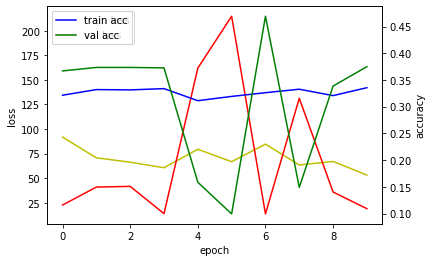

In [309]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['f1'], 'b', label='train acc')
acc_ax.plot(hist.history['val_f1'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [310]:
val_loss, val_f1, val_acc = model.evaluate(X_val, y_val, verbose=2)

163/163 - 0s - loss: 18.9303 - f1: 0.3748 - acc: 0.7750


In [311]:
print(val_loss)
print(val_f1)
print(val_acc)

18.930330276489258
0.3748477101325989
0.7750479578971863


# 3. KerasTuner

In [315]:
def model_builder(hp):
    model = keras.Sequential()

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 5, max_value = 30, step = 32)
    model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss='binary_crossentropy', 
                metrics = [f1, 'accuracy'])

    return model

In [316]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')                       

In [317]:
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_val, y_val))
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Epoch 1/2
652/652 [==============================] - ETA: 0s - loss: 472.1342 - f1: 0.2222 - accuracy: 0.781 - ETA: 0s - loss: 73.2986 - f1: 0.2962 - accuracy: 0.678 - ETA: 0s - loss: 59.2082 - f1: 0.2880 - accuracy: 0.68 - ETA: 0s - loss: 52.1899 - f1: 0.2791 - accuracy: 0.67 - ETA: 0s - loss: 49.1031 - f1: 0.2641 - accuracy: 0.67 - ETA: 0s - loss: 43.9914 - f1: 0.2745 - accuracy: 0.68 - ETA: 0s - loss: 42.0084 - f1: 0.2782 - accuracy: 0.67 - ETA: 0s - loss: 37.7712 - f1: 0.2821 - accuracy: 0.68 - ETA: 0s - loss: 36.4696 - f1: 0.2759 - accuracy: 0.68 - ETA: 0s - loss: 37.9267 - f1: 0.2738 - accuracy: 0.68 - ETA: 0s - loss: 37.1732 - f1: 0.2788 - accuracy: 0.68 - ETA: 0s - loss: 38.1980 - f1: 0.2865 - accuracy: 0.68 - ETA: 0s - loss: 37.5381 - f1: 0.2908 - accuracy: 0.68 - ETA: 0s - loss: 36.2634 - f1: 0.2996 - accuracy: 0.68 - ETA: 0s - loss: 36.1205 - f1: 0.2992 - accuracy: 0.68 - ETA: 0s - loss: 34.5517 - f1: 0.3048 - accuracy: 0.68 - ETA: 0s - loss: 33.0022 - f1: 0.3066 - accuracy:

Epoch 1/2
652/652 [==============================] - ETA: 0s - loss: 13269.2451 - f1: 0.0000e+00 - accuracy: 0.687 - ETA: 0s - loss: 11266.1211 - f1: 0.0000e+00 - accuracy: 0.771 - ETA: 0s - loss: 11407.2246 - f1: 0.0000e+00 - accuracy: 0.767 - ETA: 0s - loss: 11681.0176 - f1: 0.0000e+00 - accuracy: 0.760 - ETA: 0s - loss: 11740.5557 - f1: 0.0000e+00 - accuracy: 0.759 - ETA: 0s - loss: 11535.4268 - f1: 0.0000e+00 - accuracy: 0.760 - ETA: 0s - loss: 11468.9023 - f1: 0.0000e+00 - accuracy: 0.760 - ETA: 0s - loss: 11425.1201 - f1: 0.0000e+00 - accuracy: 0.759 - ETA: 0s - loss: 11338.0361 - f1: 0.0000e+00 - accuracy: 0.759 - ETA: 0s - loss: 11417.3223 - f1: 0.0000e+00 - accuracy: 0.756 - ETA: 0s - loss: 11350.3613 - f1: 0.0000e+00 - accuracy: 0.754 - ETA: 0s - loss: 11235.1094 - f1: 0.0000e+00 - accuracy: 0.754 - ETA: 0s - loss: 11124.1309 - f1: 0.0000e+00 - accuracy: 0.754 - ETA: 0s - loss: 10997.6445 - f1: 0.0000e+00 - accuracy: 0.755 - ETA: 0s - loss: 10907.9316 - f1: 0.0000e+00 - accur

Epoch 1/2
652/652 [==============================] - ETA: 0s - loss: 4319.8003 - f1: 0.0000e+00 - accuracy: 0.71 - ETA: 0s - loss: 701.1041 - f1: 0.1321 - accuracy: 0.6151     - ETA: 0s - loss: 427.0333 - f1: 0.2075 - accuracy: 0.645 - ETA: 0s - loss: 324.0100 - f1: 0.2488 - accuracy: 0.654 - ETA: 0s - loss: 265.6277 - f1: 0.2655 - accuracy: 0.667 - ETA: 0s - loss: 262.3035 - f1: 0.2560 - accuracy: 0.663 - ETA: 0s - loss: 232.5767 - f1: 0.2753 - accuracy: 0.669 - ETA: 0s - loss: 210.9823 - f1: 0.2809 - accuracy: 0.675 - ETA: 0s - loss: 213.3176 - f1: 0.2829 - accuracy: 0.677 - ETA: 0s - loss: 217.0718 - f1: 0.2812 - accuracy: 0.676 - ETA: 0s - loss: 206.2406 - f1: 0.2895 - accuracy: 0.675 - ETA: 0s - loss: 210.7131 - f1: 0.2879 - accuracy: 0.673 - ETA: 0s - loss: 207.1934 - f1: 0.2964 - accuracy: 0.675 - ETA: 0s - loss: 206.0238 - f1: 0.2999 - accuracy: 0.678 - ETA: 0s - loss: 204.2133 - f1: 0.3048 - accuracy: 0.678 - ETA: 0s - loss: 203.1658 - f1: 0.3057 - accuracy: 0.682 - 1s 2ms/ste

In [320]:
model_new = tuner.hypermodel.build(best_hps)
model_new.fit(X_train, y_train, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10
652/652 [==============================] - ETA: 0s - loss: 20.9120 - f1: 0.2857 - acc: 0.687 - ETA: 0s - loss: 75.8779 - f1: 0.2844 - acc: 0.671 - ETA: 0s - loss: 57.5242 - f1: 0.3393 - acc: 0.676 - ETA: 0s - loss: 46.1462 - f1: 0.3646 - acc: 0.695 - ETA: 0s - loss: 49.0069 - f1: 0.3381 - acc: 0.693 - ETA: 0s - loss: 45.9817 - f1: 0.3415 - acc: 0.689 - ETA: 0s - loss: 57.9657 - f1: 0.3258 - acc: 0.685 - ETA: 0s - loss: 64.3957 - f1: 0.3201 - acc: 0.682 - ETA: 0s - loss: 69.4788 - f1: 0.3174 - acc: 0.680 - ETA: 0s - loss: 70.9964 - f1: 0.3197 - acc: 0.680 - ETA: 0s - loss: 66.9848 - f1: 0.3306 - acc: 0.684 - ETA: 0s - loss: 66.1038 - f1: 0.3336 - acc: 0.683 - ETA: 0s - loss: 66.6385 - f1: 0.3333 - acc: 0.685 - ETA: 0s - loss: 64.0859 - f1: 0.3356 - acc: 0.683 - ETA: 0s - loss: 62.5074 - f1: 0.3338 - acc: 0.683 - ETA: 0s - loss: 60.9356 - f1: 0.3361 - acc: 0.683 - ETA: 0s - loss: 58.8501 - f1: 0.3390 - acc: 0.683 - ETA: 0s - loss: 58.9246 - f1: 0.3348 - acc: 0.683 - ETA: 0s - 

KeyboardInterrupt: 

In [ ]:
val_loss, val_f1, val_acc = model_new.evaluate(X_val, y_val, verbose=2)

In [ ]:
print(val_loss)
print(val_f1)
print(val_acc)